### Web Traffic Forecasting Project (Time Series Project using Deep Learning)

## Done By: Ashwath Bala S

## Structure of the Notebook

1. Problem Statement
2. Data Dictionary
3. Loading Libraries and Data
4. Data Exploration
5. Data Preparation
6. Training and Validation data
7. Model Building
8. Forecast for Next 6 Months

## 1. Understanding the Problem Statement

In order to dynamically manage resources to run our website, we need to have an idea about the number of visitors who might arrive at our website at different points in time.

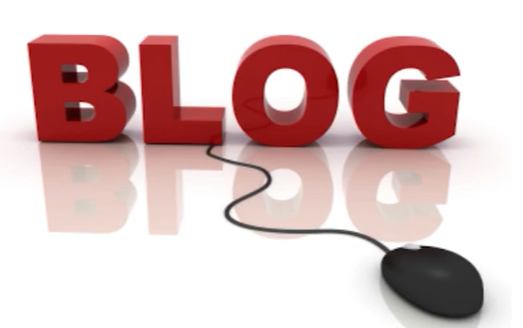

In this Project, we will predict the web traffic using the historical data

## 2. Data Dictionary

The dataset used for this project has 4,896 records and has the following columns:

(i)  Hour Index

(ii) Sessions

### 3. Loading the Libraries and the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('webtraffic.csv')

In [2]:
# Checking the shape of the dataset
data.shape

(4896, 2)

In [3]:
# Checking the top 5 rows of our dataset
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [4]:
# Sessions is the volume of traffic on the website

### 4. Data Exploration

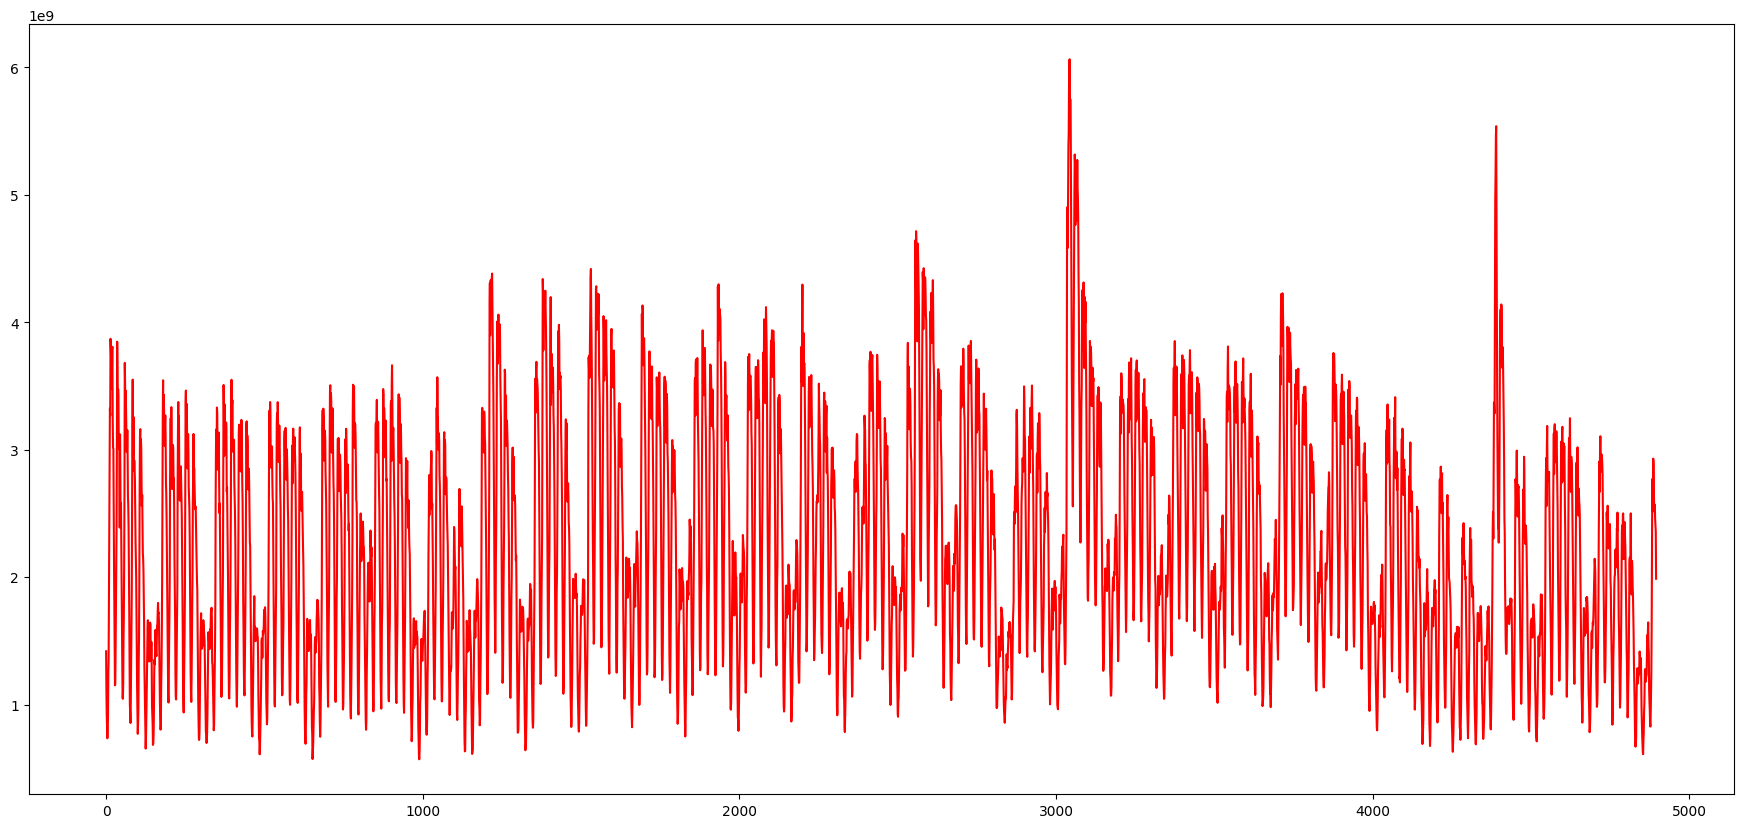

In [5]:
sessions = data['Sessions'].values

# Visualizing the entire time series data
ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()

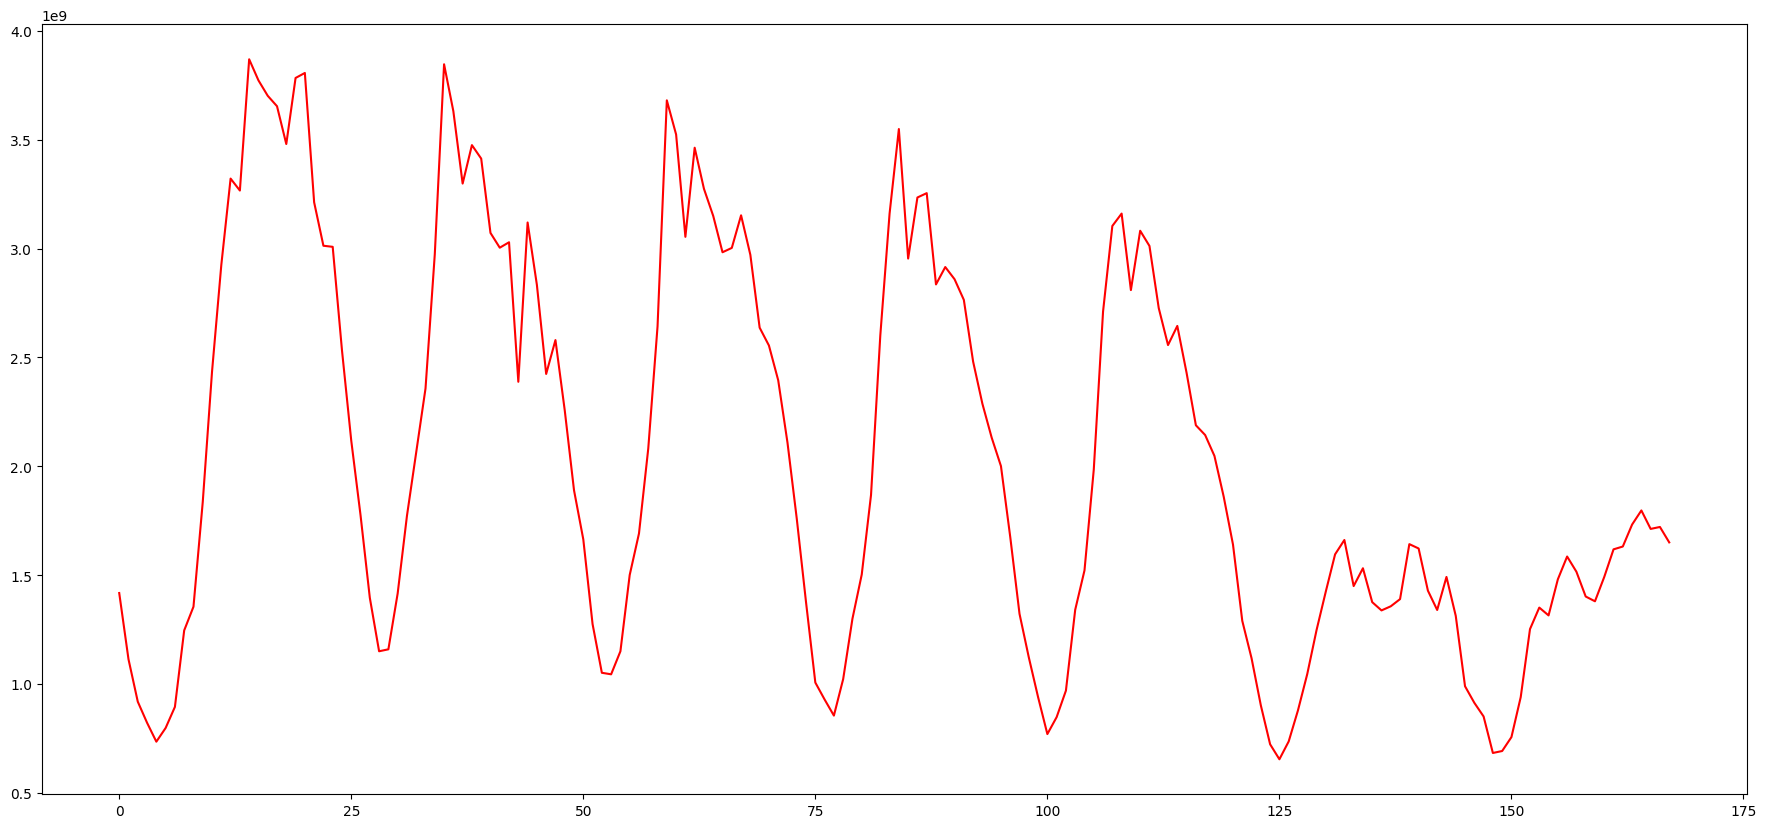

In [6]:
# Visualizing first week web traffic

sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

In [7]:
# There are two situations: One is higher traffic and the other is dips. It may be occuring once in an hour

### 5. Data Preparation

We will model the problem to predict the traffic for the next hour based on the previous week data i.e. 168 hours. Lets define a function to prepare the input and output data accordingly.

*Note: The input is a sequence of values and the output is a single value.*

Let's say we are following a sequence in which starting from first, the first 5 will be an sequence of length 5 and 6th observation will be treated as the target. Next will be 2nd element to 6th element and 7th will be the target
We will be following this method. The subsequent will be extracted by moving this window one step at a time

In [8]:
# Defining the function to prepare

def prepare_data(seq,num):
  x=[]
  y=[]

  for i in range(0,(len(seq)-num),1):

    input_ = seq[i:i+num]
    output  = seq[i+num]

    x.append(input_)
    y.append(output)

  return np.array(x), np.array(y)

In [9]:
# Calling the function
x,y= prepare_data(sessions,168)  # For 1 week

In [10]:
print(len(x))

4728


### 6. Training and Validation Data

In [11]:
ind = int(0.9 * len(x))

# training set
x_tr = x[:ind]
y_tr = y[:ind]

# validation set
x_val=x[ind:]
y_val=y[ind:]

Normalize the input and output data as it speeds up the training process

In [12]:
from sklearn.preprocessing import StandardScaler

# Normalizing the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

# Reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

# Normalizing the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

In [13]:
print(x_tr.shape)

(4255, 168)


As we can see here, the input data is a 2 dimenional array but the LSTM accepts only 3 dimensional inputs in the form of (no. of samples, no. of timesteps, no. of features)

So, reshaping the input data as per the model requirement

In our project, the three dimensions we are making are No. of Sequences, No. of Timesteps, Length of the features

In [14]:
# Reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)

In [15]:
print(x_tr.shape)

(4255, 168, 1)


In [16]:
# Note:

# Third element is the length of the feature.
# Let's say we have a 5 elements and they have a vector length of 10, then it becomes 10
# In our project, the sequence elements are real number values and thus the value is "1"

### 7. Model Building

Defining the Model Architecture

In [17]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

# Defining the Model Architecture
model =  Sequential()
model.add(LSTM(128,input_shape=(168,1)))  # We are using single layer of LSTM and Input shape is 1 week (168)
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))   # Linear because we need to predict a continuous variable and it a regression problem

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Understanding the output shape and No. of parameters of each layer

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model

Defining the Optimizer and Loss

In [19]:
model.compile(loss='mse',optimizer='adam')

Defining the callback to save the best model during the training

In [20]:
from keras.callbacks import ModelCheckpoint

# Save the model in .keras format
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Training the Model

In [21]:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
129/133 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3438
Epoch 1: val_loss improved from inf to 0.03559, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.3369 - val_loss: 0.0356
Epoch 2/30
130/133 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0429
Epoch 2: val_loss improved from 0.03559 to 0.03021, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0428 - val_loss: 0.0302
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0349
Epoch 3: val_loss did not improve from 0.03021
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0349 - val_loss: 0.0306
Epoch 4/30
127/133 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0325
Epoch 4: val_loss did not improve from 0.03021
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0325 - val_loss: 0.0340
Epoch 5/30
128/133 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0329
Epoch 5: val_loss did not improve from 0.03021
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.03

Loading the weights of best model prior to predictions

In [22]:
model.load_weights('best_model.keras')

Evaluating the Model Performance on the Validation Data

In [23]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200
Mean Square Error: 0.016139747574925423


### Comparision with Baseline Model

In [24]:
# Building a simple moving average model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

# Reshaping the data
x_reshaped = x_val.reshape(-1,168)

# Getting the predictions
y_pred = compute_moving_average(x_reshaped)

In [25]:
# Evaluating the performance of baseline model on the validation data
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print(mse)

0.5546025834434455


The MSE value of base model is 0.55 and that of LSTM Model is 0.016

Clearly, we can see our LSTM Model is performing better

### 8. Forecasting

**Steps we will be following**:

1. Intialize the array, say "data" with a weeks data
2. Predict for the next hour
3. Append the predicted value as the last element of array "data"
4. Skip the first element of array "data"
5. Repeat steps 2 to 4 for **N** iterations

Defining a function which forecasts the traffic for the next hours from the previous week data.

In [26]:
def forecast(x_val, no_of_pred, ind):
    predictions = []

    # Initializing the array with a week's data
    temp = x_val[ind]

    for i in range(no_of_pred):
        # Predict for the next hour
        pred = model.predict(temp.reshape(1, -1, 1))[0][0]

        # Appending the prediction as the last element of array
        temp = np.insert(temp, len(temp), pred)
        predictions.append(pred)

        # Ignoring the first element of array
        temp = temp[1:]

    return predictions

Now let's forecast the traffic for the next 24 hours based on the previous week data


In [27]:
# Defining parameters
no_of_pred = 24
ind = 72

# Generating predictions
y_pred = forecast(x_val, no_of_pred, ind)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [28]:
# Preparing data for inverse transformation
y_true = y_val[ind:ind + no_of_pred]
y_true = y_true.reshape(-1, 1)  # Reshaping for inverse transform
y_pred = np.array(y_pred).reshape(-1, 1)  # Converting to array and reshape

Converting back the normalized values to the original dimensional space

In [29]:
# Inverse transform
y_true = y_scaler.inverse_transform(y_true)
y_pred = y_scaler.inverse_transform(y_pred)

In [30]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

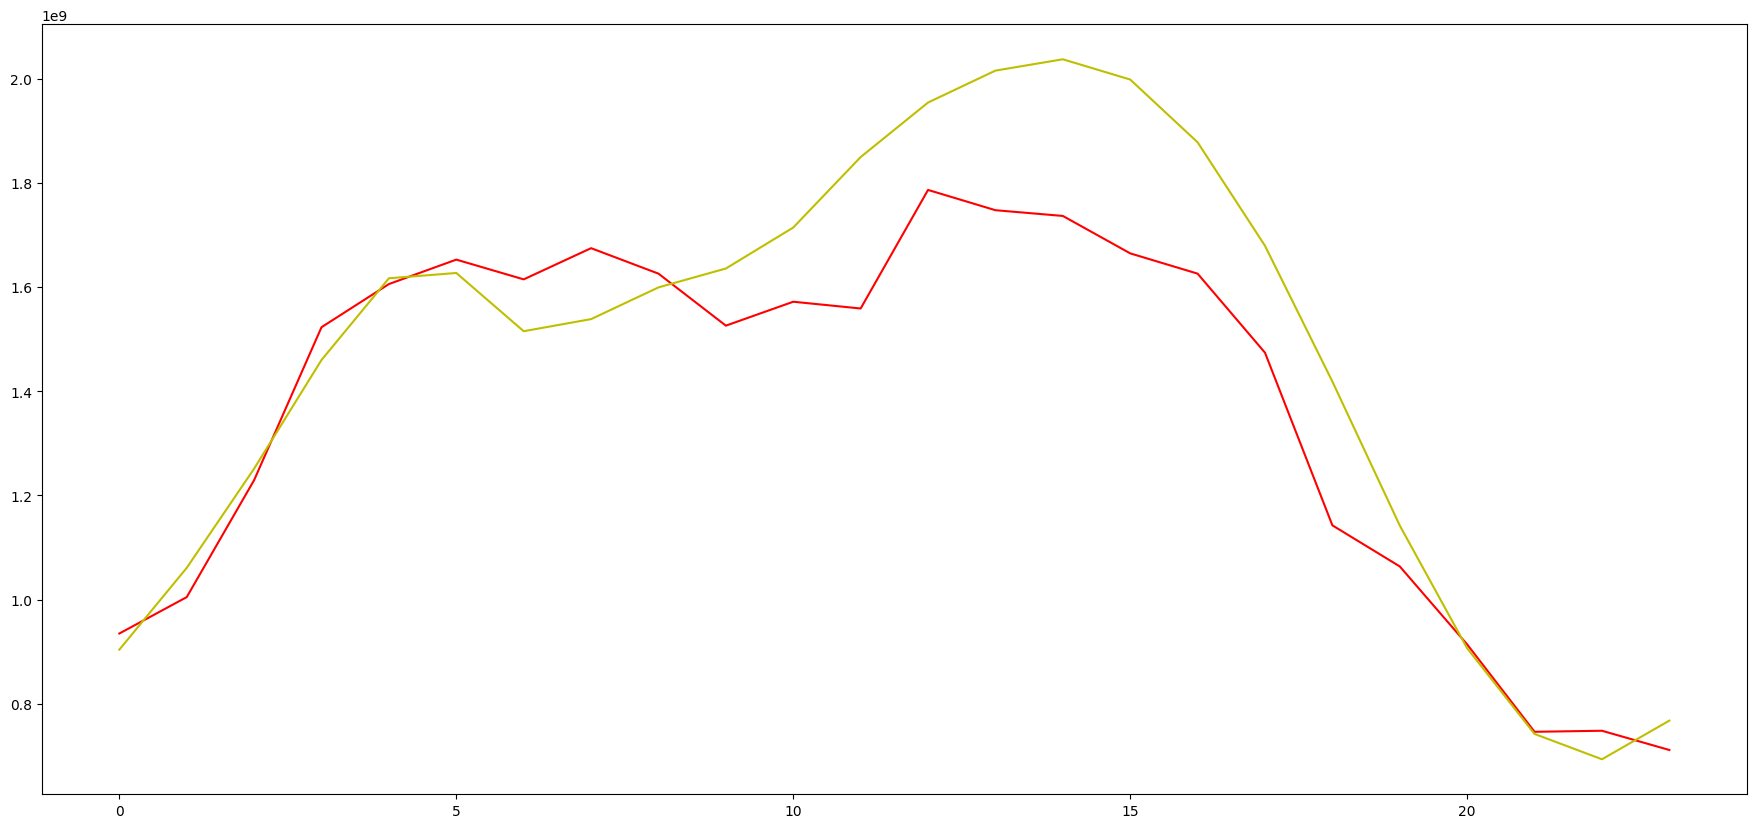

In [31]:
plot(y_true,y_pred)

## In this Project, we have built LSTM Model to forcast Web Traffic using Deep Learning Technique